In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from offline_evaluation import Evaluator
import matplotlib.pyplot as plt

In [3]:
evaluator = Evaluator(
    gcs_dt = '2022-03-14',
    ref_dt = '2022-03-06',
    objectives = [
        'proxy_a',
        'proxy_b',
        'proxy_c',
        'inc_sales',
        'p_inc_sales',
    ]
)
dfs = evaluator.get_data()

	 Reading GCS for set proxy_a...
	 Reading GCS for set proxy_b...
	 Reading GCS for set proxy_c...
	 Reading GCS for set inc_sales...
	 Reading GCS for set p_inc_sales...


In [26]:
df_m =  evaluator.get_pbq_data(model='M')
df_r =  evaluator.get_pbq_data(model='R')

	 Reading MMM_POST_BQ_MASTER_AUDIENCE for set M...
	 Reading MMM_POST_BQ_MASTER_AUDIENCE for set R...


In [9]:
sql = f'''
    SELECT 
        crn,
        template_id,
        redemption * (spend - base_spend) p_inc_sales,
    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_MODEL_SCORE_DATA`
    WHERE campaign_start_date = '2022-03-22'
'''
df_score = evaluator.bq.query(sql).result().to_dataframe()

In [11]:
df = df_m.merge(df_score, on = ['crn', 'template_id'])

In [17]:
df_sorted = df.sort_values(by='p_inc_sales', ascending=False)
df_sorted['cum_a_inc_sales'] = df_sorted['a_inc_sales'].cumsum()
df_sorted['rank'] = 1
df_sorted['rank'] = df_sorted['rank'].cumsum() / df_sorted['rank'].sum()

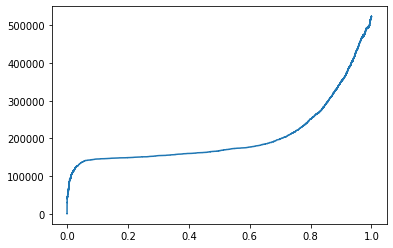

In [25]:
plt.figure()
plt.plot(df_sorted['rank'], df_sorted['cum_a_inc_sales'])
plt.show()

In [33]:
dfs['p_inc_sales'].crn.nunique()

crn      ref_dt Campaign_Seg_Grp_Id           template_id  \
0  3300000000005599813  2022-03-06              SG-009   CAT-4298_20220322_9   
1  3300000000005599826  2022-03-06              SG-012  CAT-4298_20220322_12   
2  3300000000005599828  2022-03-06              SG-012  CAT-4298_20220322_12   
3  3300000000005599831  2022-03-06              SG-009   CAT-4298_20220322_9   
4  3300000000005599837  2022-03-06              SG-010  CAT-4298_20220322_10   

   inc_sales  p_inc_sales ranking_segment  
0  -7.014340    -0.016041               0  
1  -1.069786    -0.001464               0  
2   0.472998     0.008577               0  
3 -12.073532    -0.268584               0  
4   0.579592     0.001138               0

In [30]:
df_r.shape

(3505210, 3)

In [37]:
test = dfs['p_inc_sales'].merge(df_r, on = ['crn'])

In [38]:
test.shape

(3505210, 9)